Here we will used the simple model introduced in notebook '03-baseline_model.ipynb' using class_weight = 'auto' while fitting because it seemed to give the best results for accuracy and loss.

We still need to verify metrics as FRR and FAR.

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# Data augmentation

In [2]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Sample of transformations applied.

In [3]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os

train_SIM_dir = '../data/TTG_TUR/train/SIM'

fnames = [os.path.join(train_SIM_dir, fname) for fname in os.listdir(train_SIM_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(128, 128))

# Convert it to a Numpy array with shape (128, 128, 3)
x = image.img_to_array(img)

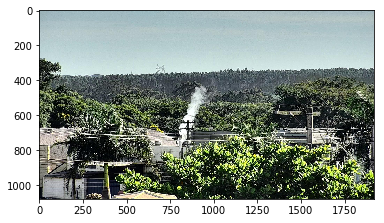

In [4]:
# Original image

plt.imshow(image.load_img(img_path))

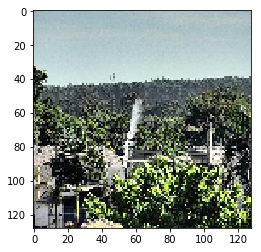

In [5]:
# RE-sized image
plt.imshow(img)

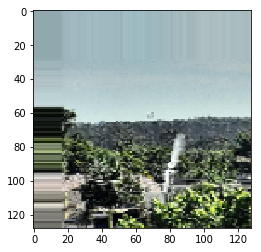

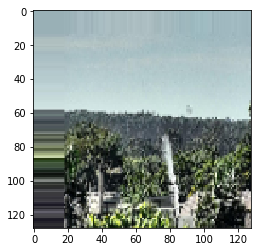

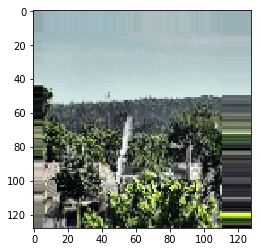

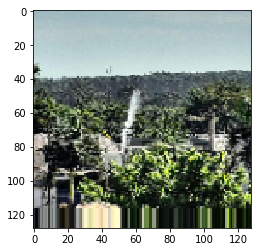

In [6]:
# Generated images

# Reshape it to (1, 128, 128, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

# New baseline model adding dropout

The model is similar to the one used previously (notebook 03-baseline_model.ipynb). The only difference is an additional dropout layer to also help fighting overfitting.


In [7]:
from keras import layers
from keras import models

input_shape = (128,128,3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)      

In [9]:
#saving model

model.save("../models/baseline_model_omdena_plus_dropout_v011119.h5")

# loading model to test

from keras.models import load_model

model = load_model("../models/baseline_model_omdena_plus_dropout_v011119.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)      

c:\program files\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Compile model

In [10]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Training the model

The new model will be trained using data augmentation provided by keras.

## Data pre-processing and data augmentation

In [12]:
import os

base_dir = "../data/TTG_TUR/"

train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')


train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(128, 128),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


## Fitting the model

In [13]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-12-14 20:51:16.350117


In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 146s 1s/step - loss: 0.5640 - acc: 0.7561 - val_loss: 0.6431 - val_acc: 0.7544
Epoch 2/100
100/100 [==============================] - 142s 1s/step - loss: 0.5416 - acc: 0.7646 - val_loss: 0.4853 - val_acc: 0.7709
Epoch 3/100
100/100 [==============================] - 147s 1s/step - loss: 0.5477 - acc: 0.7597 - val_loss: 0.3688 - val_acc: 0.7588
Epoch 4/100
100/100 [==============================] - 155s 2s/step - loss: 0.5367 - acc: 0.7638 - val_loss: 0.5636 - val_acc: 0.7665
Epoch 5/100
100/100 [==============================] - 153s 2s/step - loss: 0.5267 - acc: 0.7677 - val_loss: 0.5489 - val_acc: 0.7601
Epoch 6/100
100/100 [==============================] - 150s 2s/step - loss: 0.5313 - acc: 0.7617 - val_loss: 0.4772 - val_acc: 0.7652
Epoch 7/100
100/100 [==============================] - 149s 1s/step - loss: 0.5247 - acc: 0.7647 - val_loss: 0.6456 - val_acc: 0.7696
Epoch 8/100
100/100 [==============================] - 148s 1s

Epoch 62/100
100/100 [==============================] - 147s 1s/step - loss: 0.4509 - acc: 0.8059 - val_loss: 0.5017 - val_acc: 0.7824
Epoch 63/100
100/100 [==============================] - 154s 2s/step - loss: 0.4598 - acc: 0.8034 - val_loss: 1.2279 - val_acc: 0.7734
Epoch 64/100
100/100 [==============================] - 147s 1s/step - loss: 0.4443 - acc: 0.8042 - val_loss: 0.3989 - val_acc: 0.7893
Epoch 65/100
100/100 [==============================] - 149s 1s/step - loss: 0.4612 - acc: 0.7966 - val_loss: 0.3570 - val_acc: 0.7891
Epoch 66/100
100/100 [==============================] - 149s 1s/step - loss: 0.4430 - acc: 0.8018 - val_loss: 0.4245 - val_acc: 0.7760
Epoch 67/100
100/100 [==============================] - 149s 1s/step - loss: 0.4536 - acc: 0.8056 - val_loss: 0.2641 - val_acc: 0.7904
Epoch 68/100
100/100 [==============================] - 148s 1s/step - loss: 0.4423 - acc: 0.7989 - val_loss: 0.4114 - val_acc: 0.7849
Epoch 69/100
100/100 [==============================] -

# Analysis of the results
## Learning Curves

In [15]:
def smooth_curve(points, factor=0.8):
    """ Make curves smoother"""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

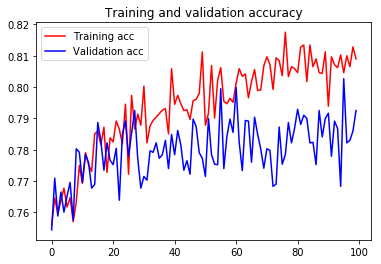

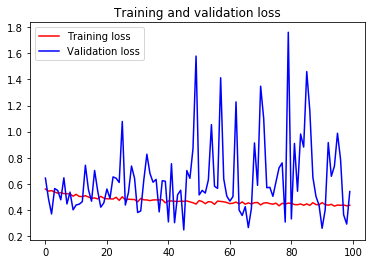

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

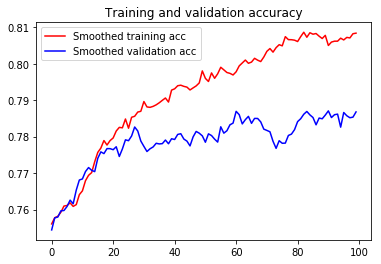

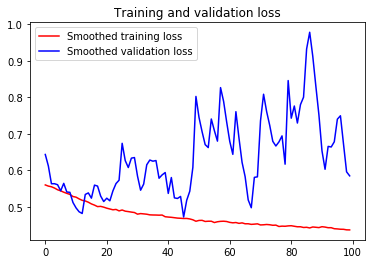

In [17]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../history/baseline_model_omdena_history_using_class_weight_auto_and_data_augmentation_v011119.csv", index = False)

In [19]:
t2 = datetime.datetime.now()
(print(t2))
print(t2-t1)

2019-12-15 01:01:48.735887
4:10:32.385770


In [20]:
df.head()

,val_loss,val_acc,loss,acc
0,0.643133,0.754419,0.559773,0.756067
1,0.485256,0.770939,0.543555,0.764576
2,0.368781,0.758838,0.547706,0.759687
3,0.563583,0.766497,0.536722,0.763750
4,0.548880,0.760101,0.527696,0.767728


In [21]:
df['diff_acc'] = abs(df['acc']-df['val_acc'])
df['diff_loss'] = abs(df['loss']-df['val_loss'])

In [22]:
df.head()

,val_loss,val_acc,loss,acc,diff_acc,diff_loss
0,0.643133,0.754419,0.559773,0.756067,0.001648,0.083360
1,0.485256,0.770939,0.543555,0.764576,0.006363,0.058299
2,0.368781,0.758838,0.547706,0.759687,0.000849,0.178926
3,0.563583,0.766497,0.536722,0.763750,0.002747,0.026861
4,0.548880,0.760101,0.527696,0.767728,0.007627,0.021184


In [23]:
df.sort_values('diff_acc').head(10)

,val_loss,val_acc,loss,acc,diff_acc,diff_loss
10,0.437721,0.769571,0.518976,0.769304,0.000267,0.081256
11,0.443568,0.778553,0.502736,0.779063,0.000509,0.059168
12,0.462724,0.775884,0.501874,0.775292,0.000592,0.039150
7,0.445427,0.757614,0.524130,0.757012,0.000602,0.078703
2,0.368781,0.758838,0.547706,0.759687,0.000849,0.178926
16,0.701951,0.782828,0.491327,0.781595,0.001234,0.210624
60,0.467162,0.799874,0.447724,0.801250,0.001376,0.019438
0,0.643133,0.754419,0.559773,0.756067,0.001648,0.083360
51,0.549211,0.789975,0.463872,0.791680,0.001705,0.085339
95,0.987441,0.802665,0.436933,0.804601,0.001936,0.550507


In [24]:
df.sort_values('diff_loss').head()

,val_loss,val_acc,loss,acc,diff_acc,diff_loss
21,0.487649,0.780457,0.484970,0.789159,0.008702,0.002679
89,0.436117,0.789975,0.439325,0.811250,0.021275,0.003208
8,0.536124,0.780303,0.522115,0.763315,0.016988,0.014009
65,0.424513,0.776015,0.443376,0.801765,0.025750,0.018863
60,0.467162,0.799874,0.447724,0.801250,0.001376,0.019438


In [25]:
df.sort_values('acc', ascending=False).head()

,val_loss,val_acc,loss,acc,diff_acc,diff_loss
76,0.722351,0.778409,0.430963,0.817500,0.039091,0.291388
84,0.881460,0.782197,0.435288,0.813438,0.031241,0.446173
82,0.542733,0.791035,0.439561,0.813438,0.022402,0.103172
98,0.290873,0.785985,0.430796,0.812813,0.026828,0.139923
81,0.909386,0.788071,0.440601,0.812795,0.024724,0.468784


From above plots and tables we can observe that is possible to achieve accuracy around 79% for both training and validation datasets (e.g. 22 epochs) with smallest absolute difference in loss between train and validation datasets (0.003). 

In [36]:
df.iloc[21]

val_loss     0.487649
val_acc      0.780457
loss         0.484970
acc          0.789159
diff_acc     0.008702
diff_loss    0.002679
Name: 21, dtype: float64

## Comparing with the results without augmentation and without extra dropout

From previous results:

In [27]:
df_no_augmentation = pd.read_csv("../history/baseline_model_omdena_history_using_class_weight_auto_v011119.csv")

In [28]:
df_no_augmentation['diff_acc'] = abs(df_no_augmentation['acc']-df_no_augmentation['val_acc'])
df_no_augmentation['diff_loss'] = abs(df_no_augmentation['loss']-df_no_augmentation['val_loss'])

In [29]:
df_no_augmentation.columns

Index(['val_loss', 'val_acc', 'loss', 'acc', 'diff_acc', 'diff_loss'], dtype='object')

In [38]:
df_no_augmentation = df_no_augmentation[['val_loss', 'val_acc','loss','acc','diff_acc', 'diff_loss']]

In [39]:
df_no_augmentation.sort_values('diff_loss').head()

,val_loss,val_acc,loss,acc,diff_acc,diff_loss
28,0.419385,0.764228,0.427927,0.810197,0.045969,0.008542
27,0.477405,0.858871,0.519160,0.754000,0.104871,0.041755
10,0.542449,0.731707,0.468330,0.800000,0.068293,0.074120
11,0.305686,0.853831,0.457364,0.813000,0.040831,0.151678
12,0.383508,0.744919,0.561919,0.728420,0.016499,0.178412


In [40]:
df_no_augmentation.sort_values('acc', ascending = False).head()

,val_loss,val_acc,loss,acc,diff_acc,diff_loss
23,0.100853,0.830285,0.428389,0.844523,0.014238,0.327535
14,0.097381,0.785569,0.420088,0.830389,0.044820,0.322707
11,0.305686,0.853831,0.457364,0.813000,0.040831,0.151678
8,0.166655,0.729675,0.428989,0.811206,0.081532,0.262334
6,1.010089,0.770161,0.424983,0.810500,0.040339,0.585106


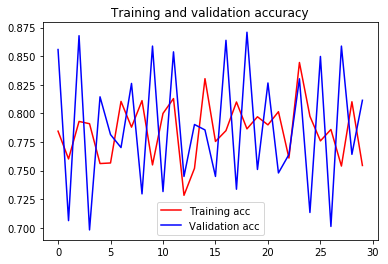

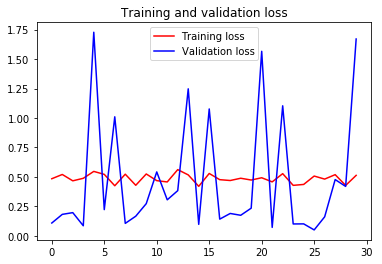

In [33]:
import matplotlib.pyplot as plt

acc = df_no_augmentation['acc']
val_acc = df_no_augmentation['val_acc']
loss = df_no_augmentation['loss']
val_loss = df_no_augmentation['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

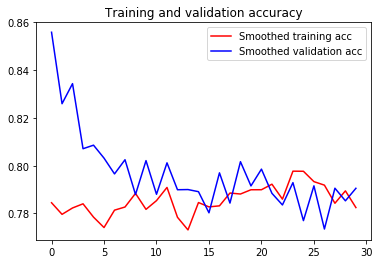

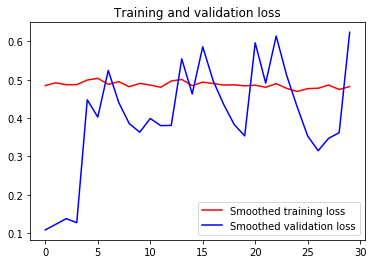

In [34]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

When using data augmentation and considering the smallest value in diff_loss (epoch 29) an accuracy in validation of 0.76 and in training of 0.81.

However, we can observe that in some cases the accuracy in validation is higher than in training indicating underfitting. Therefore, something to consider to fight this underfitting is increasing the model.

In [42]:
df_no_augmentation.iloc[28]

val_loss     0.419385
val_acc      0.764228
loss         0.427927
acc          0.810197
diff_acc     0.045969
diff_loss    0.008542
Name: 28, dtype: float64

Following we work with more complex models and pre-trained NN. We still need to consider metrics as FAR, FRR, etc that are important for the problem considered.

**REFERENCES:**


* https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

* https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

* https://keras.io/preprocessing/image/

* https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

* https://github.com/keras-team/keras/issues/6499

* https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

* https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models

To calculate other metrics 

* https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

To check imbalanced data:

* https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

* https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

* https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

* https://github.com/keras-team/keras/issues/1875

